## Analysis notebook for atmosphere NetCDF files

### Define utils

In [1]:
#%config InlineBackend.figure_format='retina'

import numpy as np
import netCDF4 as nc
import glob
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

In [2]:
def readncdf(f):

    ds = nc.Dataset(f)
    vars = list(ds.variables.keys())

    nlev_c = len(ds.variables["p"][:])
    nlev_l = len(ds.variables["pl"][:])
    tsurf  = float(ds.variables["tstar"][:])
    psurf  = float(ds.variables["pl"][-1])
    gases  = [str(bytearray(s).decode()).strip() for s in ds.variables["gases"][:]]
    asf    = float(ds.variables["toa_heating"][:])

    data = {
        "nlev_c":       nlev_c,
        "nlev_l":       nlev_l,
        "tstar":        tsurf,
        "psurf":        psurf,
        "gases":        gases,
        "toa_heating":  asf, 
    }

    for k in vars:
        if k in data.keys():
            continue 
        data[k] = np.array(ds.variables[k][:], dtype=float)
    
    ds.close()
    return data

def readrun(f):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")
    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]
    mask = np.argsort(years)
    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([readncdf(f) for f in ncdfs])
    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data


### Do analysis

In [3]:
earthy, earthd = readrun("../output/pgrid_earth_gridtest_10/case_00002/")

Reading files in '../output/pgrid_earth_gridtest_10/case_00002/'...
    Done reading 219 files
    Final time = 7.362e+05 years


In [4]:
print(list(earthd[0].keys()))

['nlev_c', 'nlev_l', 'tstar', 'psurf', 'gases', 'toa_heating', 'p', 'pl', 'tmp', 'tmpl', 'z', 'zl', 'gravity', 'mmw', 'x_gas', 'fl_D_LW', 'fl_U_LW', 'fl_N_LW', 'fl_D_SW', 'fl_U_SW', 'fl_N_SW', 'fl_D', 'fl_U', 'fl_N', 'rad_hr']


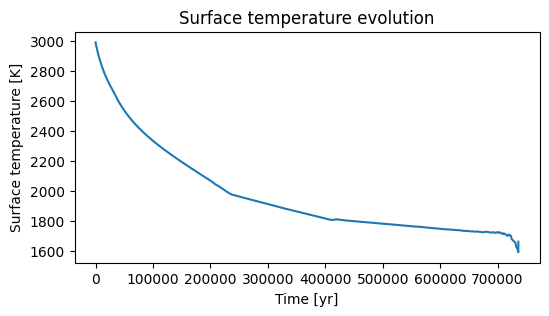

In [5]:
fig,ax = plt.subplots(figsize=(6,3))
yarr = [d["tstar"] for d in earthd]
ax.plot(earthy, yarr)
ax.set_xlabel("Time [yr]")
ax.set_ylabel("Surface temperature [K]")
ax.set_title("Surface temperature evolution")
plt.show()

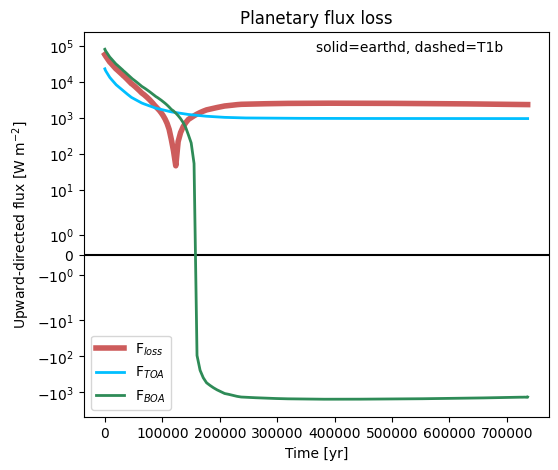

In [6]:
fig,ax = plt.subplots(figsize=(6,5))

lw = 2.0

ax.axhline(y=0, color='k')

# Colors
c_toa =  'deepskyblue'
c_boa =  'seagreen'
c_loss = 'indianred'

# earthd
toa  = [d["fl_N"][0] for d in earthd]
boa  = [d["fl_N"][-1] for d in earthd]
loss = [abs(toa[i]-boa[i]) for i in range(len(toa))]

ax.plot(earthy, loss, lw=lw*2, color=c_loss, label="F$_{loss}$")
ax.plot(earthy, toa,  lw=lw,   color=c_toa,  label="F$_{TOA}$")
ax.plot(earthy, boa,  lw=lw,   color=c_boa,  label="F$_{BOA}$")

# trap1bd
# toa  = [d["fl_N"][0] for d in trap1bd]
# boa  = [d["fl_N"][-1] for d in trap1bd]
# loss = [abs(toa[i]-boa[i]) for i in range(len(toa))]
# ax.plot(trap1by, loss, lw=lw*2, color=c_loss, linestyle='dashed')
# ax.plot(trap1by, toa,  lw=lw,   color=c_toa,  linestyle='dashed')
# ax.plot(trap1by, boa,  lw=lw,   color=c_boa,  linestyle='dashed')

ax.text(0.5, 0.95, "solid=earthd, dashed=T1b", transform=ax.transAxes)

ax.set_xlabel("Time [yr]")
ax.set_ylabel("Upward-directed flux [W m$^{-2}$]")
ax.set_title("Planetary flux loss")
ax.set_yscale("symlog")

ax.legend()
plt.show()

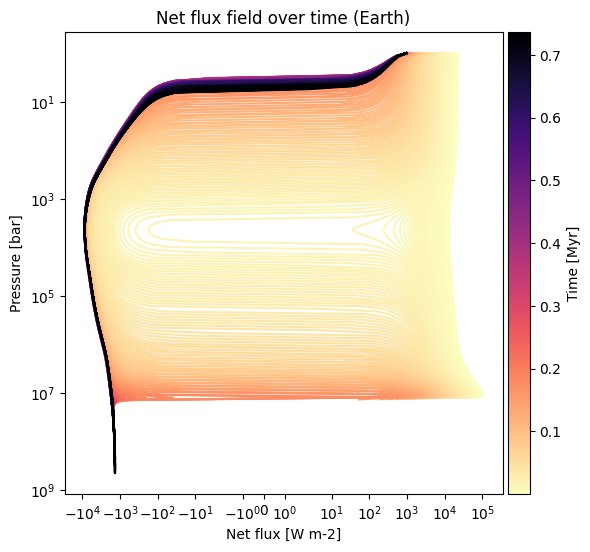

In [7]:
def plot_fluxes(yrs, dat, name):
    fig,ax = plt.subplots(figsize=(6,6))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    norm = mpl.colors.Normalize(vmin=max(yrs[0],1)/1e6, vmax=yrs[-1]/1e6)
    sm = plt.cm.ScalarMappable(cmap='magma_r', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label("Time [Myr]")

    # ax.axvline(x=0, color='black', lw=0.8)

    for i in range(0,len(dat),1):
        y=yrs[i]
        x_plt = dat[i]["fl_N"]
        y_plt = dat[i]["pl"]
        ax.plot(x_plt,y_plt, color=sm.to_rgba(y/1e6))

    ax.set_xlabel("Net flux [W m-2]")
    ax.set_ylabel("Pressure [bar]")
    ax.set_xscale("symlog")
    ax.set_yscale("log")
    ax.invert_yaxis()
    ax.set_title("Net flux field over time (%s)" % name)

    plt.show()

plot_fluxes(earthy, earthd, "Earth")
# plot_fluxes(trap1by, trap1bd, "TRAPPIST-1 b")